# Testing out different Vectorizers and regressors

## Vectorizers

    1. tf-idf vs tf vs count
    2. max_features?
    3. stop_words?
    4. ngrams?

Feature importance?


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [ ]:
df = pd.read_parquet('300_companies_tweets.parquet.gzip')
print(df.dtypes)
X = df['text']
y = df['Total ESG Risk Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', XGBRegressor(verbosity=1))
])

search_grid = {
    'vect': [TfidfVectorizer(), TfidfVectorizer(use_idf=False), CountVectorizer()],
    'vect__strip_accents': ['ascii', 'unicode'],
    'vect__max_features': [50_000],
    'vect__stop_words': ['english', None],
    'vect__ngram_range': [(1, 1), (1, 2)]
}
grid = GridSearchCV(pipe, search_grid, n_jobs=6, verbose=1,
                    scoring=['explained_variance',
                             'max_error',
                             'neg_mean_absolute_error',
                             'neg_mean_squared_error',
                             'neg_root_mean_squared_error',
                             'neg_mean_squared_log_error',
                             'neg_median_absolute_error',
                             'r2',
                             'neg_mean_absolute_percentage_error'
                             ], refit='neg_root_mean_squared_error')

grid.fit(X_train, y_train)
results_cv = pd.DataFrame(grid.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'vect': TfidfVectorizer(max_features=50000, strip_accents='unicode'), 'vect__max_features': 50000, 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__strip_accents': 'unicode'}
-7.664757943350436
|                                              | 0                                                            | 1                                                            | 2                                                            | 3                                                            | 4                                                            | 5                                                            | 6                                                            | 7                                                            | 8                              | 9                              | 10                             | 11                             | 12                             | 13                             | 14                             | 15      

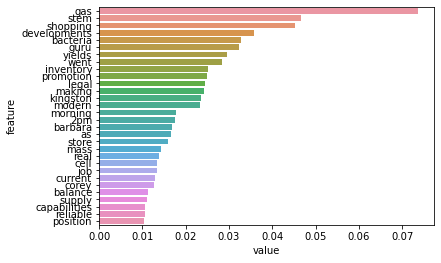

In [75]:
print(grid.best_params_)
print(grid.best_score_)

reg = grid.best_estimator_.named_steps['model']
vect = grid.best_estimator_.named_steps['vect']
zipped = zip(vect.get_feature_names(), reg.feature_importances_)
feature_importance = pd.DataFrame(zipped, columns=["feature", "value"])

feature_importance = feature_importance.sort_values('value', ascending=False)

sns.barplot(data=feature_importance[:30], y='feature', x='value')
# results_cv.sort_values('rank_test_score')
# print(results_cv.T.to_markdown())
mean_test_cols = results_cv.columns[results_cv.columns.map(lambda s: s.startswith('mean_test_'))]
print(results_cv[['param_vect', *mean_test_cols]].T.to_markdown())

|scoring                                | 0                    | 1                                                                                | 2                    |
|:--------------------------------------|:---------------------|:---------------------------------------------------------------------------------|:---------------------|
| param_vect                            | TfidfVectorizer()    | TfidfVectorizer(use_idf=False)                                                   | CountVectorizer()    |
| mean_test_explained_variance          | -0.12090433082425692 | -0.06772101097404042                                                             | -0.09089732154585824 |
| mean_test_max_error                   | -27.04721336364746   | -26.51073303222656                                                               | -27.219509506225585  |
| mean_test_neg_mean_absolute_error     | -6.535389967759452   | -6.39905297756195                                                                | -6.466684373219809   |
| mean_test_neg_mean_squared_error      | -74.04808001762976   | -71.21629400804467                                                               | -72.09946951419028   |
| mean_test_neg_root_mean_squared_error | -8.58037791381701    | -8.399850912116605                                                               | -8.468936758801416   |
| mean_test_neg_mean_squared_log_error  | -0.11201294188095626 | -0.10629419776168776                                                             | -0.10779743617805057 |
| mean_test_neg_median_absolute_error   | -5.322534370422363   | -4.901313209533692                                                               | -5.226981353759766   |

In [73]:
8.399850912116605 / y.mean()

0.34681465367946346